In [1]:
%matplotlib inline

# Bible NLP

In this notebook, we will apply some natural language processing techniques to some chocen texts from the Gospels.

The goal is to verify the behavior of these techniques with these particular texts, in particular if they can capture information without changing the meaning of the text.

The verses are taken from the tables of Synoptic Gospel Parallels from [gospelparallels.com](https://www.gospelparallels.com/index.html).

We will consider every table as a single category, and we will use the verses as documents.

The verses are taken using the API from [bible-api.com](https://bible-api.com).

In [2]:
import time
import pandas as pd
import requests

# Given a reference return the text of the verse
def get_verse_text(verse: str):
    query = verse.replace(' ', '+')
    url = f'https://bible-api.com/{query}'
    response = requests.get(url)

    if response.status_code == 200:
        json = response.json()
        return json['reference'], json['text'], response.status_code
    else:
        return verse, None, response.status_code

def load_data(verses):
    verses_text = {}
    i = 0
    for verse in verses:
        wait = 4
        while True:
            ref, text, code = get_verse_text(verse)

            if code == 200:
                i += 1
                verses_text[ref] = text
                print(f'{i}/{len(verses)}: {ref}')
                break
            elif code == 429:
                print(f"Error {code}, next attempt in", wait, "seconds")
                time.sleep(wait)
                wait *= 2
            else:
                print(f"Error {code} for {ref}")
                break

    return pd.DataFrame({'verse': verses_text.keys(), 'text': verses_text.values()})

In [3]:
import os
import pandas as pd
import regex as re
from collections import defaultdict

def load_dataset(path_to_save: str, path_to_dataset: str):
    verses = defaultdict(lambda: ['', set()])
    for filename in os.listdir(path_to_dataset):
        f = os.path.join(path_to_dataset, filename)
        df = pd.read_csv(f, sep=',', encoding='utf-8', index_col=0)
        for index, row in df.iterrows():
            for col in df.columns:
                if pd.notnull(row[col]):
                    vs = row[col].split('\n ')
                    for verse in vs:
                        verse = re.sub(r'[a-z]+', '', verse)
                        verses[f"{col} {verse}"][1].add(filename.replace('.csv', ''))
                        verses[f"{col} {verse}"][0] = index

    df = load_data(verses)
    df['category'] = df['verse'].apply(lambda x: ';'.join(verses[x][1]))
    df['pericope'] = df['verse'].apply(lambda x: verses[x][0])
    df.to_csv(path_to_save, sep=',', encoding='utf-8')

In [4]:
import os
import pandas as pd

if not os.path.exists('data/verses.csv'):
    load_dataset('data/verses.csv', 'data/verses')

verses_df = pd.read_csv('data/verses.csv', sep=',', encoding='utf-8')
verses_df['category'] = verses_df['category'].apply(lambda x: list(x.split(';')))

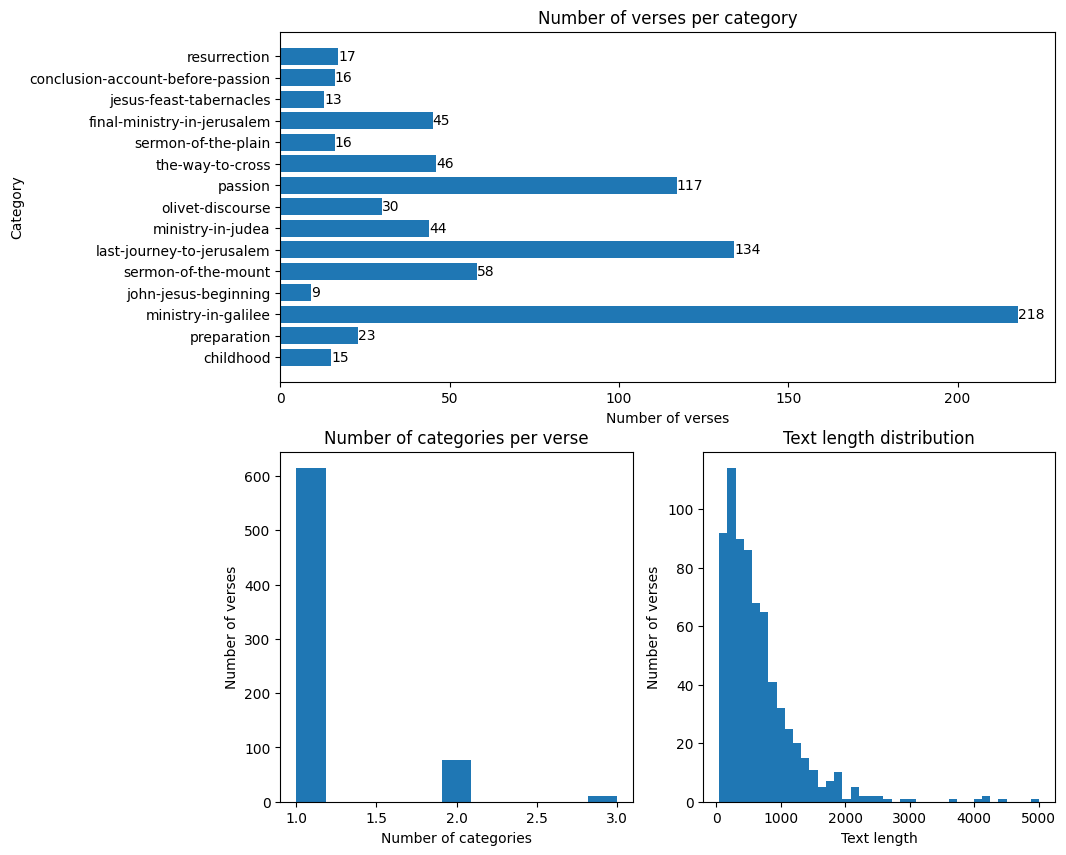

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt

category_verses = defaultdict(int)
for categories in verses_df['category']:
    for category in categories:
        category_verses[category] += 1

categories = list(category_verses.keys())

verses_category = {}
texts_length = {}
for _, row in verses_df.iterrows():
    verses_category[row['verse']] = len(row['category'])
    texts_length[row['verse']] = len(row['text'])

_, axd = plt.subplot_mosaic([['upper', 'upper'], ['lower left', 'lower right']], figsize=(10, 10))

bars = axd['upper'].barh(categories, list(category_verses.values()))
axd['upper'].bar_label(bars)
axd['upper'].set(xlabel='Number of verses', ylabel='Category', title='Number of verses per category')

axd['lower left'].hist(list(verses_category.values()), bins='auto')
axd['lower left'].set(xlabel='Number of categories', ylabel='Number of verses', title='Number of categories per verse')

axd['lower right'].hist(list(texts_length.values()), bins='auto')
axd['lower right'].set(xlabel='Text length', ylabel='Number of verses', title='Text length distribution')
plt.show()

The distribution of the categories in the dataset is not very balanced and we have a conspicuous number of verses that belong to 2 or more categories.

With regards to the distribution of the lenght of the texts we can see that the majority of the verses are short (below 1000 characters), but there are also some outliers that are very long (above 5000 characters).

## Classification

In this task we will try to classificate the texts using entropy and information gain for scoring the words, and then we will compare three different classifiers: Naive Bayes, Decision Tree and Random Forest.

So, because we have some verses that belong to more than one category and we want to use a classifier that can only assign one category to each sample, we will use the following strategy: if a sample belongs to more than one category, the sample will be deleted.

This is necessary because entropy and information gain (as we defined them) doesn't have a way to deal with multilabel data.

We will only consider the categories that have at least 25 samples. This threshold is chosen because it consent us to have a better balanced dataset and to have a good number of samples for maintaining stable the results of the classifiers among different runs.

In [6]:
import pandas as pd

verses_df = pd.read_csv('data/verses.csv', sep=',', encoding='utf-8')

verses_df['category'] = verses_df['category'].apply(lambda x: x.split(';'))
verses_df = verses_df[verses_df['category'].apply(lambda x: len(x) == 1)]
verses_df['category'] = verses_df['category'].apply(lambda x: x[0])

allowed_categories = verses_df['category'].value_counts()
allowed_categories = allowed_categories[allowed_categories >= 25].index.tolist()

verses_df = verses_df[verses_df['category'].isin(allowed_categories)][['verse', 'text', 'category']]
verses_df.reset_index(drop=True, inplace=True)
verses_df

,verse,text,category
0,Matthew 4:12,Now when Jesus heard that John was delivered u...,ministry-in-galilee
1,Mark 1:14,"Now after John was taken into custody, Jesus c...",ministry-in-galilee
2,Luke 4:14,Jesus returned in the power of the Spirit into...,ministry-in-galilee
3,John 4:1-3,Therefore when the Lord knew that the Pharisee...,ministry-in-galilee
4,John 4:4-42,He needed to pass through Samaria.\nSo he came...,ministry-in-galilee
...,...,...,...
517,Matthew 27:57-61,"When evening had come, a rich man from Arimath...",passion
518,Mark 15:42-47,"When evening had now come, because it was the ...",passion
519,Luke 23:50-56,"Behold, a man named Joseph, who was a member o...",passion
520,John 19:38-42,"After these things, Joseph of Arimathaea, bein...",passion


In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
import numpy as np

def preprocess(text, n):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    ngrams_set = set()
    for i in range(1, n+1):
        processed_text = ngrams(tokens, i)
        ngrams_set.update([' '.join(gram) for gram in processed_text])
    return ngrams_set

def build_token_dictionary(tokens: pd.Series):
    tokens_dict = defaultdict(set)
    for idx, record in enumerate(tokens):
        for token in record:
            tokens_dict[token].add(idx)
    return tokens_dict
    
def entropy(df: pd.DataFrame):
    categories = df['category'].unique()
    entropy = 0
    for label in categories:
        p = len(df[df['category'] == label]) / len(df)
        entropy -= p * np.log(p)
    return entropy
    
def information_gain(df: pd.DataFrame, H, token: str):
    token_df = df[df['tokens'].apply(lambda x: token in x)]
    token_count = len(token_df)
    token_entropy = entropy(token_df)
    return H - token_count / len(df) * token_entropy

verses_df['tokens'] = verses_df['text'].apply(preprocess, n=3)
tokens_dict = build_token_dictionary(verses_df['tokens'])
df_tokens = pd.DataFrame(zip(tokens_dict.keys(), tokens_dict.values()), columns=['token', 'verses'])
count = []
for t in df_tokens['verses']:
    count.append(len(t))
df_tokens['count'] = count
df_tokens = df_tokens[df_tokens['count'] > 1]

H = entropy(verses_df)
df_tokens['information_gain'] = df_tokens['token'].apply(lambda x: information_gain(verses_df, H, x))
df_tokens.sort_values(by='information_gain', ascending=False, inplace=True)

For reducing the effect of unbalanced classes in dataset, we will use a Stratified 10-Folds cross-validator for training and testing the classifiers.

For comparing the classifiers we will use the mean accuracy over the 10 folds.

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix

def to_numeric(df: pd.DataFrame, best_features: pd.DataFrame, threshold):
    index = {}
    for idx, token in enumerate(best_features['token']):
        index[token] = idx
    data = np.zeros((len(df), threshold))
    target = np.empty(len(df), dtype=object)
    
    for idx, record in df.iterrows():
        for token in record['new_text']:
            data[idx, index[token]] = 1
        
        target[idx] = record['category']
            
    return data, target

def classification(clf, df: pd.DataFrame, verses_df: pd.Series, threshold):
    df_tokens = df[:threshold]

    new_texts = []
    for tokens in verses_df['tokens']:
        intesect = set(tokens).intersection(set(df_tokens['token'].values))
        new_texts.append(intesect)
    verses_df['new_text'] = new_texts
    numeric_df, target = to_numeric(verses_df, df_tokens, threshold)

    scores = cross_val_score(clf, numeric_df, target, cv=StratifiedKFold(n_splits=10), n_jobs=-1)
    predictions = cross_val_predict(clf, numeric_df, target, cv=StratifiedKFold(n_splits=10), n_jobs=-1)
    return scores.mean(), confusion_matrix(target, predictions, labels=allowed_categories)

naive_bayes = MultinomialNB()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

x_axis = range(100, 450, 50)

scores = {}
for threshold in x_axis:
    a1, c1 = classification(naive_bayes, df_tokens, verses_df, threshold)
    a2, c2 = classification(decision_tree, df_tokens, verses_df, threshold)
    a3, c3 = classification(random_forest, df_tokens, verses_df, threshold)
    scores[threshold] = {
        'accuracy' : {
            'naive_bayes': a1, 
            'decision_tree': a2, 
            'random_forest': a3
            }, 
        'confusion_matrix': {
            'naive_bayes': pd.DataFrame(c1, index=allowed_categories, columns=allowed_categories),
            'decision_tree': pd.DataFrame(c2, index=allowed_categories, columns=allowed_categories),
            'random_forest': pd.DataFrame(c3, index=allowed_categories, columns=allowed_categories)
        }
    }

As metrics for evaluating the classifiers we will use the average accuracy among the folds and the confusion matrixes.

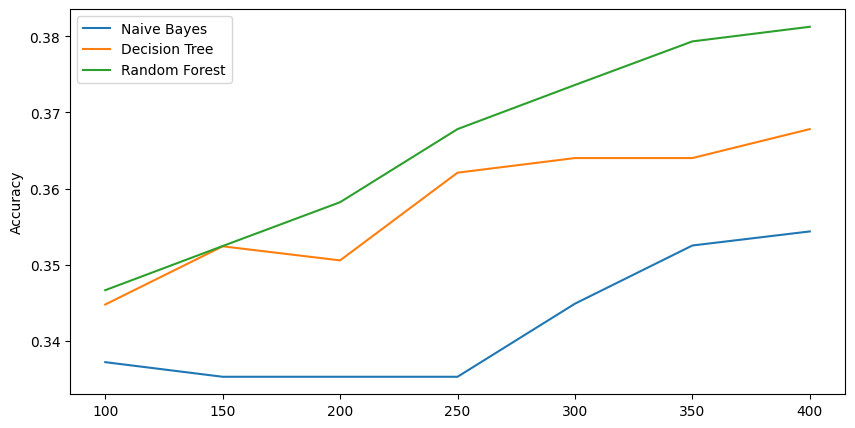

In [9]:
import matplotlib.pyplot as plt
labels = ['Naive Bayes', 'Decision Tree', 'Random Forest']

plt.figure(figsize=(10, 5))
plt.plot(x_axis, [list(x['accuracy'].values()) for x in scores.values()], label=labels)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The results are the following:

- the best classifier (for average accuracy) is the Random Forest, the worst is the Naive Bayes.

- the best results are obtained with Random Forest at 350 features,

- the maximum accuracy is around 35%-40%, similar to the percentage of the most frequent category in the dataset in all cases, so this suggests that the classifiers tend to predict the most frequent category.

Let's analyze the predictions made by the three models at their maximum accuracy features using the confusion matrix.

In [10]:
nb = zip(x_axis, [x['accuracy']['naive_bayes'] for x in scores.values()])
dt = zip(x_axis, [x['accuracy']['decision_tree'] for x in scores.values()])
rf = zip(x_axis, [x['accuracy']['random_forest'] for x in scores.values()])

max_nb_idx, max_nb = max(nb, key=lambda x: x[1])
max_dt_idx, max_dt = max(dt, key=lambda x: x[1])
max_rf_idx, max_rf = max(rf, key=lambda x: x[1])

print(f"Confusion matrix of Random Forest with {max_rf_idx} features")
display(scores[max_rf_idx]['confusion_matrix']['random_forest'])
print(f"Accuracy: {max_rf:.4f}\n")

print(f"Confusion matrix of Decision Tree with {max_dt_idx} features")
display(scores[max_dt_idx]['confusion_matrix']['decision_tree'])
print(f"Accuracy: {max_dt:.4f}\n")

print(f"Confusion matrix of Naive Bayes with {max_nb_idx} features")
display(scores[max_nb_idx]['confusion_matrix']['naive_bayes'])
print(f"Accuracy: {max_nb:.4f}\n")

Confusion matrix of Random Forest with 400 features


,ministry-in-galilee,passion,last-journey-to-jerusalem,the-way-to-cross,final-ministry-in-jerusalem,ministry-in-judea,sermon-of-the-mount,olivet-discourse
ministry-in-galilee,175,0,0,0,0,0,0,0
passion,111,0,0,0,0,0,0,0
last-journey-to-jerusalem,75,0,0,0,0,0,0,0
the-way-to-cross,42,0,0,0,0,0,0,0
final-ministry-in-jerusalem,26,0,0,0,12,0,0,0
ministry-in-judea,18,0,0,0,0,10,0,0
sermon-of-the-mount,27,0,0,0,0,0,0,0
olivet-discourse,26,0,0,0,0,0,0,0


Accuracy: 0.3813

Confusion matrix of Decision Tree with 400 features


,ministry-in-galilee,passion,last-journey-to-jerusalem,the-way-to-cross,final-ministry-in-jerusalem,ministry-in-judea,sermon-of-the-mount,olivet-discourse
ministry-in-galilee,175,0,0,0,0,0,0,0
passion,111,0,0,0,0,0,0,0
last-journey-to-jerusalem,75,0,0,0,0,0,0,0
the-way-to-cross,42,0,0,0,0,0,0,0
final-ministry-in-jerusalem,30,0,0,0,8,0,0,0
ministry-in-judea,21,0,0,0,0,7,0,0
sermon-of-the-mount,27,0,0,0,0,0,0,0
olivet-discourse,26,0,0,0,0,0,0,0


Accuracy: 0.3678

Confusion matrix of Naive Bayes with 400 features


,ministry-in-galilee,passion,last-journey-to-jerusalem,the-way-to-cross,final-ministry-in-jerusalem,ministry-in-judea,sermon-of-the-mount,olivet-discourse
ministry-in-galilee,174,1,0,0,0,0,0,0
passion,111,0,0,0,0,0,0,0
last-journey-to-jerusalem,75,0,0,0,0,0,0,0
the-way-to-cross,42,0,0,0,0,0,0,0
final-ministry-in-jerusalem,17,16,0,0,5,0,0,0
ministry-in-judea,16,6,0,0,0,6,0,0
sermon-of-the-mount,27,0,0,0,0,0,0,0
olivet-discourse,26,0,0,0,0,0,0,0


Accuracy: 0.3544



The confusion matrixes show that the all models tend to predict the "ministry-in-galilee" category for almost all samples, and this is the reason why the accuracy is similar to the percentage of this category in the dataset.

All models predicted correctly a few samples for "final-ministry-in-jerusalem" and "ministry-in-judea". The Random Forest has the best results because it predicted correctly the most samples of these two categories and the rest of the predictions are almost the same as the other models.

## Clustering

In this section we will try to cluster the texts using K-Means and TD-IDF technique.

The goal is to see if parallel texts are clustered together varying the number of clusters.

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

def preprocess(text, n):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token.isalpha() and (
        token not in stopwords.words('english'))]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(
        token) for token in filtered_tokens]
    if n <= 1:
        return lemmatized_tokens
    ngram_set = []
    for i in range(1, n + 1):
        processed_text = ngrams(lemmatized_tokens, i)
        ngram_set.extend([' '.join(grams) for grams in processed_text])
    return ngram_set

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

verses_df = pd.read_csv('data/verses.csv', sep=',', encoding='utf-8')
verses_df = verses_df[['verse', 'pericope', 'text']]

verses_df['tokens'] = verses_df['text'].apply(preprocess, n=1)
verses_df['tokens'] = verses_df['tokens'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(verses_df['tokens'])

Now, before applying the clustering algorithm, we will try to find the optimal number of clusters using the elbow method and the silhouette score.

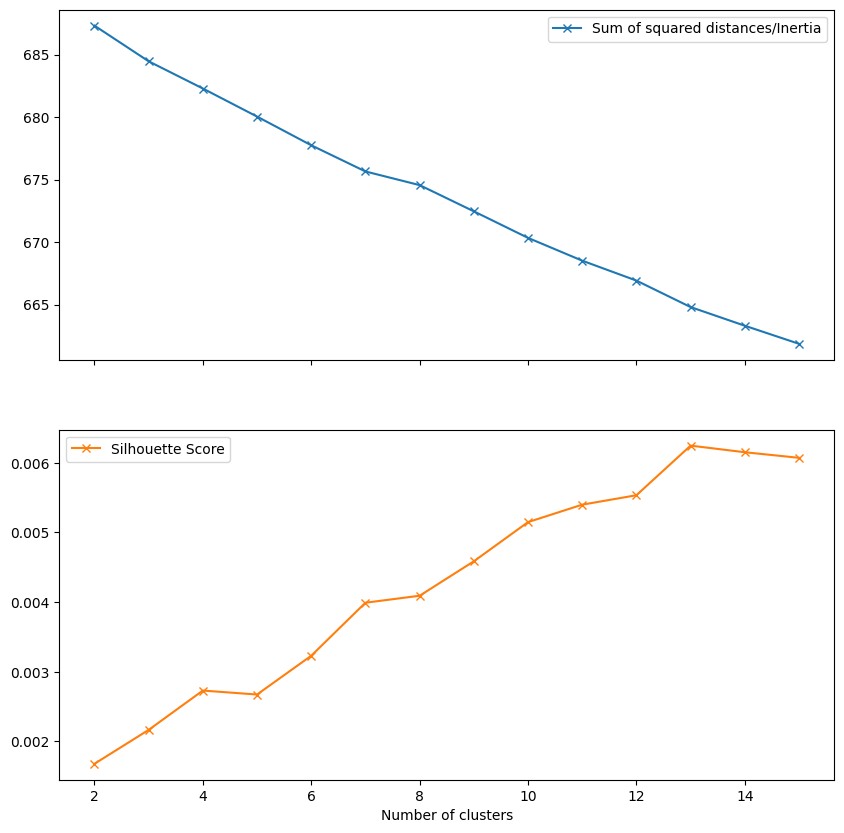

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def silouette_score(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
    return kmeans.inertia_, silhouette_score(X, kmeans.labels_)

interitas = []
scores = []
for i in range(2, len(categories) + 1):
    inertia, score = silouette_score(X, i)
    interitas.append(inertia)
    scores.append(score)

df = pd.DataFrame({'Number of clusters': range(2, len(categories)+1) ,'Sum of squared distances/Inertia': interitas, 'Silhouette Score': scores})
df.plot(x='Number of clusters', y=['Sum of squared distances/Inertia', 'Silhouette Score'], figsize=(10, 10), subplots=True, marker='x')
plt.show()

From the graph of inertia we cannot find a clear elbow, so we will use only the silhouette score.

The maximum silhouette score is obtained with 13 clusters, but the score is nearly 0, so we can say that we are in presence of overlapping clusters.

In [14]:
import numpy as np
import pandas as pd

def get_top_keywords(X, n_terms, vectorizer):
    df = pd.DataFrame(X.todense()).groupby(verses_df['cluster']).mean()
    terms = vectorizer.get_feature_names_out()

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))

kmeans = KMeans(n_clusters=13, random_state=0, n_init='auto').fit(X)
verses_df['cluster'] = kmeans.labels_
get_top_keywords(X, 20, vectorizer)


Cluster 0
thing,one,man,people,took,king jew,crucify,jew,king,put,barabbas,jesus,chief,chief priest,priest,saying,said,release,pilate,day

Cluster 1
even,taken,divorce wife,away,another commits,marries another,taken away,serve,wife,said,among,whoever given,commits adultery,adultery,commits,marries,divorce,one,whoever,shall

Cluster 2
cause one,around neck,millstone hung,mother brother,little,occasion,around,cause,seven,stumble,woe,brother sin,better,seven time,one little,little one,one,sin,brother,forgive

Cluster 3
name,forgiven,life lose,man coming,follow,come,sky,let,coming,save,loses,said,day,one,lose,whoever,son man,son,life,man

Cluster 4
reward,pray,take,produce,tree produce,also,lost,one,hear,evil,even,tree,collector,tax collector,salt,tax,fruit,sinner,good,love

Cluster 5
prince demon,demon cast,jordan,prince,sick,multitude,divided,came,healed,jerusalem,brought,mute,possessed demon,beelzebul,went,cast demon,galilee,possessed,cast,demon

Cluster 6
three,might,sought,rooster,ma

Let's see if the texts with the same pericope are clustered together.

In [15]:
pericopes = verses_df[['pericope', 'verse', 'cluster']].groupby(['pericope', 'cluster']).count()

pericopes.reset_index(inplace=True)
pericopes[pericopes.duplicated(subset=['pericope'], keep=False)].sort_values(by='pericope')

,pericope,cluster,verse
5,Commissioning the Seventy,9,2
6,Commissioning the Seventy,12,1
7,Commissioning the Twelve,0,1
8,Commissioning the Twelve,1,1
9,Commissioning the Twelve,9,2
...,...,...,...
467,"“He who Hears You, Hears Me”",1,1
468,"“He who Hears You, Hears Me”",12,1
470,"“He who has Ears to Hear, Let him Hear”",4,1
469,"“He who has Ears to Hear, Let him Hear”",1,2


The clustering algorithm didn't cluster together the texts with the same pericope.

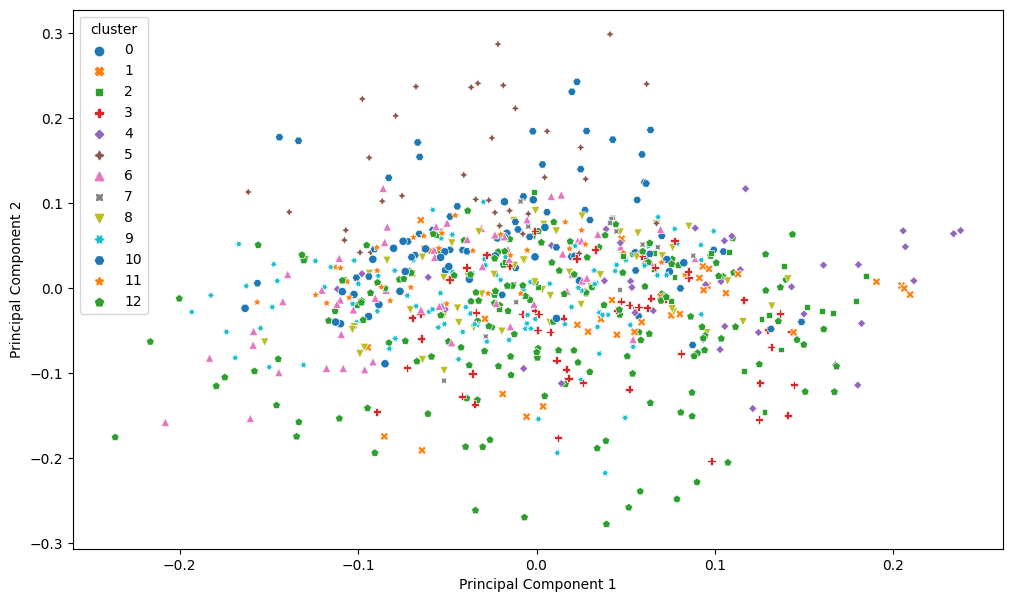

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

verses_df['x0'] = principal_components[:, 0]
verses_df['x1'] = principal_components[:, 1]

plt.figure(figsize=(12, 7))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
sns.scatterplot(data=verses_df, x='x0', y='x1', hue='cluster', palette='tab10', style='cluster')
plt.show()

The PCA plot shows that the clusters are not well separated, confirming the results of the silhouette score.

The obtained clusters seems quite different from the real categories, in fact reading the feature words of the clusters seems that the clustering algorithm has grouped the texts for macro-arguments, for example the cluster 0 talks about the Passion of Jesus, while the cluster 1 talks about marriage and divorce.

The problem is that there a are a lot of words that are common to all clusters, so the clustering algorithm cannot distinguish well the texts.

## Summarization

In this section we will try to summarize some texts using Sentence Scoring and Sentence Extraction techniques.

- The Sermon on the Mount (Matthew 5-7)

- The Last Supper from the Gospel of John (John 13-17)

- The Parable of the Prodigal Son (Luke 15,11-32)

- The Passion of Jesus from the Gospel of Luke (Luke 22-23)

In [17]:
def summarizing_verses():
    verses = [
        'Matthew 5:1-7:29', # Sermon on the Mount
        'John 13:1-17:26',  # The Last Supper
        'Luke 22:1-23:56',  # The Passion
        'Luke 15:11-32',    # Parable of the Prodigal Son
    ]
    verses_df = load_data(verses)
    verses_df.to_csv('data/summarizing_verses.csv', index=False)

In [18]:
import os
import pandas as pd

if not os.path.exists('data/summarizing_verses.csv'):
    summarizing_verses()
    
verses_df = pd.read_csv('data/summarizing_verses.csv')
verses_df

,verse,text
0,Matthew 5:1-7:29,"Seeing the multitudes, he went up onto the mou..."
1,John 13:1-17:26,"Now before the feast of the Passover, Jesus, k..."
2,Luke 22:1-23:56,"Now the feast of unleavened bread, which is ca..."
3,Luke 15:11-32,"He said,\n“A certain man had two sons.\n\n\nTh..."


In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
import numpy as np
import re

def preprocess(text, lemmatizer, n):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha(
    ) and token not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if n <= 1:
        return tokens

    ngrams_set = []
    for i in range(1, n+1):
        processed_text = ngrams(tokens, i)
        ngrams_set.extend([' '.join(grams) for grams in processed_text])
    return ngrams_set

def gen_summary(sentences, scores, threshold):
    summary = []
    for idx, sentence in enumerate(sentences):
        s = re.sub(r'\s+', ' ', sentence)
        if scores[idx] >= threshold:
            summary.append(s)
    return summary

def threshold(*args):
    return args[1] * np.mean(list(args[0]))

For Sentence Scoring, instead of using frequentistic methods (like TF-IDF), we will use Latent Dirichlet Allocation (LDA) to find the most important topics in the text and use the probability of the tokens in the topics as weight. If a tokens compares in more than one topic, the sum of the probabilities is used.

The score of a sentence is calculated in this way:

1. the sentence is tokenized in words and the tokens are lemmatized

2. for each token if the token is in the list of the most important tokens obtained from LDA, the score of the token is added to the score of the sentence

3. the score of the sentence is divided by the number of relevant tokens found during the previous step (in this way short sentences are not penalized)

In [20]:
from gensim import corpora, models

def text_lda(sentences):
    lemmatizer = WordNetLemmatizer()
    tokens = [preprocess(sentence, lemmatizer, 1) for sentence in sentences]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=4)

    scores = defaultdict(lambda: 0)
    for topic, _ in lda.top_topics(corpus, coherence='u_mass', topn=10):
        for score, token in topic:
            scores[token] += score

    return dict(scores)

def score_sentence_lda(sentences, lda_scores, lemmatizer):
    sentence_score = {}
    for idx, sentence in enumerate(sentences):
        score = 0
        relevant_tokens = 0
        for token in word_tokenize(sentence.lower()):
            token = lemmatizer.lemmatize(token)
            if token in lda_scores:
                score += lda_scores[token]
                relevant_tokens += 1
        sentence_score[idx] = score / relevant_tokens if relevant_tokens > 0 else 0
    return sentence_score

In [21]:
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
verses_df['sentences'] = verses_df['text'].apply(sent_tokenize)
verses_df['lda_scores'] = verses_df['sentences'].apply(text_lda)
verses_df['sentence_scores'] = verses_df.apply(lambda x: score_sentence_lda(x['sentences'], x['lda_scores'], lemmatizer), axis=1)

In [22]:
verses_df['alpha'] = [1.8, 1.5, 1.6, 1]
verses_df['summary'] = verses_df.apply(lambda x: gen_summary(x['sentences'], x['sentence_scores'], threshold(x['sentence_scores'].values(), x['alpha'])), axis=1)

for _, row in verses_df.iterrows():
    print(row['verse'])
    print('\n'.join(row['summary']))
    print(f"\nOriginal size: {len(row['sentences'])} sentences, summary size: {len(row['summary'])} sentences")
    print("\n")

Matthew 5:1-7:29
Whoever, therefore, shall break one of these least commandments, and teach others to do so, shall be called least in the Kingdom of Heaven; but whoever shall do and teach them shall be called great in the Kingdom of Heaven.
For I tell you that unless your righteousness exceeds that of the scribes and Pharisees, there is no way you will enter into the Kingdom of Heaven.
Most certainly I tell you, you shall by no means get out of there, until you have paid the last penny.
“You have heard that it was said, ‘You shall not commit adultery;’ but I tell you that everyone who gazes at a woman to lust after her has committed adultery with her already in his heart.
“Again you have heard that it was said to them of old time, ‘You shall not make false vows, but shall perform to the Lord your vows,’ but I tell you, don’t swear at all: neither by heaven, for it is the throne of God; nor by the earth, for it is the footstool of his feet; nor by Jerusalem, for it is the city of the gr

The model used for Sentence Scoring seems to work well.

The summaries obtained are coherent with the original texts. In particular we observe a tendency to summarize the texts using long sentences, which is good for this kind of texts, but it is bad for the size of the summaries.

Very appreciated is the fact that the start of dialogs are almost always included in the summaries, which is very important for understanding the context (this was a problem with the summaries obtained using frequentistic methods like TF-IDF).

## Conclusions

The result obtained for the classification and clustering tasks are not very good.

I think that the main problem is in the dataset in particular in:

- the unbalancing of the categories,

- the nature of these: they are made according to combined chronological (two verses are in the same category because they are near in the original text) and thematic criteria and it seems that the tecniques used are not able to capture the first criteria,

    - probably a way to improve the results could be adding the information about the order of the verses in the original text (e.g. something like positional encoding).

For the summarising task, the results are promising, so I think that the model used is good for this kind of texts, but the summaries obtained are quite long, so the model should be improved, for example by trying different methods for scoring the sentences and calculating the summaries.